# WNTR Geospatial Tutorial
The following tutorial illustrates the use of the `wntr.gis` module to use geospatial data in resilience analysis.  The objective of this tutorial is to 1) quantify water service disruptions that could occur from pipes damaged in landslides and 2) identify the social vulnerability of populations impacted by the service disruptions.

To simplify the tutorials, it is assumed that pipes within a 1000 ft buffer of each landslide susceptible region are damaged in that landslide.
This assumption could be replaced with detailed landslide analysis that includes slope, soil type, weather conditions, and pipe material.
Social vulnerability data could also be replaced by datasets that describe other attributes of the population and critical services.

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Geopandas is used to load geospatial data
- Shapely is used to define a region of interest to crop data
- Matplotlib is used to create subplots

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pylab as plt
import wntr

## Units
WNTR uses SI (International System) units.  See https://usepa.github.io/WNTR/units.html for more details.

In [2]:
# The following line defines coordinates used to zoom in on network graphics
zoom_coords = [(5.75e6, 5.79e6), (3.82e6, 3.85e6)] 

# Water Network Model
The following section creates a `WaterNetworkModel` object from an EPANET INP file and converts the model to GeoDataFrames for use in geospatial analysis.

## Create a WaterNetworkModel from an EPANET INP file
The water distribution network model used in this tutorial was downloaded from the [UKnowledge Water Distribution Systems Research Database](https://uknowledge.uky.edu/wdsrd/). KY10 was selected for the analysis. The following section creates a `WaterNetworkModel` from an EPANET INP file and computes some general attributes of the model.

Citation: Hoagland, Steven, "10 KY 10" (2016). Kentucky Dataset. 12. https://uknowledge.uky.edu/wdst/12. Accessed on 4/4/2024.

In [3]:
# Create a WaterNetworkModel from an EPANET INP file
inp_file = '../networks/ky10.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [4]:
# Print a basic description of the model. 
# The level can be 0, 1, or 2 and defines the level of detail included in the description.
wn.describe(level=1)

{'Nodes': {'Junctions': 920, 'Tanks': 13, 'Reservoirs': 2},
 'Links': {'Pipes': 1043, 'Pumps': 13, 'Valves': 5},
 'Patterns': 4,
 'Curves': {'Pump': 0, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 6}

In [5]:
# Compute total pipe length
length = wn.query_link_attribute('length')
total_length = length.sum() # m
print('Total pipe length =', total_length, 'm, =', total_length*3.28084, 'ft')

Total pipe length = 430025.7699696 m, = 1410845.7471470626 ft


In [6]:
# Compute average expected demand per day 
average_expected_demand = wntr.metrics.average_expected_demand(wn) # m^3/s
average_volume_per_day = average_expected_demand*(24*3600) # m^3
total_water_use = average_volume_per_day.sum() # m^3
print('Total water use =', total_water_use, 'm^3, =', total_water_use*264.172/1e6, 'million gallons')

Total water use = 8180.260818317952 m^3, = 2.16099586089669 million gallons


In [7]:
# Estimate population using the default average volume of water consumed per capita per day of 200 gallons/day
population = wntr.metrics.population(wn) 
total_population = population.sum()
print('Total population =', total_population)

Total population = 10799.0


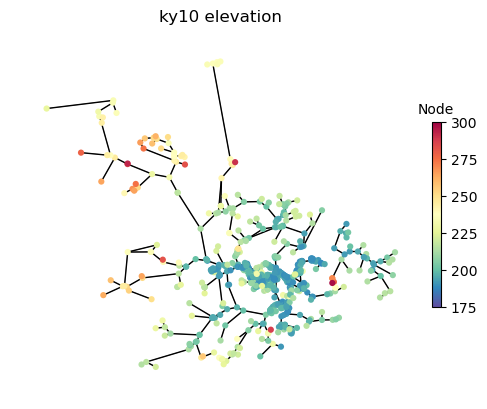

In [8]:
# Create a basic network graphic, showing junction elevation
# Note, the remaining graphics in this tutorial are created from the geospatial data directly, rather than the `plot_network` function.
# The `plot_network` function currently does not include vertices.
ax = wntr.graphics.plot_network(wn, node_attribute='elevation', node_range=(175, 300), title='ky10 elevation')

## Convert the WaterNetworkModel to GIS data
The `WaterNetworkModel` is converted to a collection of GIS compatible GeoDataFrames and the coordinate reference system (CRS) is set to EPSG:3089 (NAD83 / Kentucky Single Zone (ftUS), see https://epsg.io/3089 for more details).  Data for junctions, tanks, reservoirs, pipes, pumps, and valves are stored in separate GeoDataFrames.

In [9]:
# Convert the WaterNetworkModel to GIS data and set the CRS
wn_gis = wn.to_gis()
wn_gis.junctions.head()
#wn_gis.tanks.head()
#wn_gis.reservoirs.head()
#wn_gis.pipes.head()
#wn_gis.pumps.head()
#wn_gis.tanks.head()


,node_type,elevation,initial_quality,geometry
J-1,Junction,218.079889,0.0,POINT (5765080.500 3843715.000)
J-10,Junction,244.449966,0.0,POINT (5763552.050 3874637.000)
J-100,Junction,195.045300,0.0,POINT (5759532.400 3834262.000)
J-101,Junction,213.592014,0.0,POINT (5755474.000 3830288.000)
J-102,Junction,189.579382,0.0,POINT (5774010.920 3832605.000)


In [10]:
# Set the CRS to EPSG:3089 (NAD83 / Kentucky Single Zone (ftUS))
crs = 'EPSG:3089'
wn_gis.set_crs(crs)

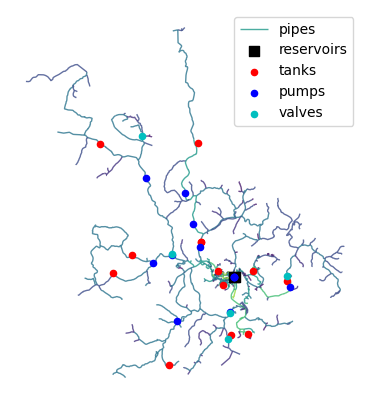

In [11]:
# Use the GIS data to create a figure of the network
fig, ax = plt.subplots(figsize=(5,5))
ax = wn_gis.pipes.plot(column='diameter', linewidth=1, label='pipes', alpha=0.8, ax=ax, zorder=1)
ax = wn_gis.reservoirs.plot(color='k', marker='s', markersize=60, label='reservoirs', ax=ax)
ax = wn_gis.tanks.plot(color='r', markersize=20, label='tanks', ax=ax)
ax = wn_gis.pumps.centroid.plot(color='b', markersize=20, label='pumps', ax=ax)
ax = wn_gis.valves.centroid.plot(color='c', markersize=20, label='valves', ax=ax)
tmp = ax.axis('off')
# Uncomment the following lines to zoom in on the network graphic
#tmp = ax.set_xlim(zoom_coords[0])
#tmp = ax.set_ylim(zoom_coords[1])
tmp = plt.legend()

## Save the GIS data to GeoJSON or Shapefile files
The GIS data can be written to GeoJSON files or Shapefile files.  One file is created for junctions, tanks, reservoirs, pipes, pumps, and valves (ky10_junctions.geojson, ky10_tanks.geojson, etc.).  Note that controls, patterns, curves, and options are not included in the GIS formatted data files.  The GeoJSON or Shapefile files can be loaded into GIS software platforms for further analysis.

In [12]:
# Store the WaterNetworkModel as a collection of GeoJSON files
wn_gis.write_geojson('ky10')

# External GIS Data
The external data used in this tutorial includes landslide inventory and social vulnerability data.

## Load landslide GIS data
The landslide data used in this tutorial was downloaded from the [UKnowledge Kentucky Geological Survey Research Data](https://uknowledge.uky.edu/kgs_data/).  The Kentucky Geological Survey Landslide Inventory from March 2023 was selected for the analysis.  The data contains locations of known landslides and areas susceptible to debris flows, derived from aerial photography. 

Citation: Crawford, M.M., 2023. Kentucky Geological Survey landslide inventory [2023-03]: Kentucky Geological Survey Research Data, https://uknowledge.uky.edu/kgs_data/7/, Accessed on 4/4/2024.

In [13]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file.
# The region of interest (ROI) includes a 5000 ft buffer surrounding all pipes. The function `box` was imported from shapely.
"""
bounds = wn_gis.pipes.total_bounds # total_bounds returns the upper and lower bounds on x and y
geom = box(*bounds)
ROI = geom.buffer(5000) # feet

landslide_file = '../data/KGS_Landslide_Inventory_exp.gdb'
landslide_data = gpd.read_file(landslide_file, driver="FileGDB", layer='Areas_derived_from_aerial_photography')
print(landslide_data.crs)
landslide_data = landslide_data.clip(ROI)
landslide_data.to_file("../data/ky10_landslide_data.geojson", index=True, driver='GeoJSON')
"""

'\nbounds = wn_gis.pipes.total_bounds # total_bounds returns the upper and lower bounds on x and y\ngeom = box(*bounds)\nROI = geom.buffer(5000) # feet\n\nlandslide_file = \'../data/KGS_Landslide_Inventory_exp.gdb\'\nlandslide_data = gpd.read_file(landslide_file, driver="FileGDB", layer=\'Areas_derived_from_aerial_photography\')\nprint(landslide_data.crs)\nlandslide_data = landslide_data.clip(ROI)\nlandslide_data.to_file("../data/ky10_landslide_data.geojson", index=True, driver=\'GeoJSON\')\n'

In [14]:
# Load the landslide data from file and print the CRS to ensure it is in EPSG:3089.  
# The methods `to_crs` and `set_crs` can be used to change coordinate reference systems if needed.
landslide_file = '../data/ky10_landslide_data.geojson'
landslide_data = gpd.read_file(landslide_file).set_index('index') 
print(landslide_data.crs)

landslide_data.head()

EPSG:3089


,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry
index,,,,,,
12158,Landslide,LANCER,3,600.093659,25776.421953,"POLYGON ((5795711.138 3796524.413, 5795749.332..."
12154,Landslide,LANCER,3,525.280081,18705.404676,"POLYGON ((5793900.026 3796635.524, 5793945.165..."
7509,Landslide,Prestonsburg,3,331.655229,7830.582786,"POLYGON ((5769026.666 3797014.993, 5769050.971..."
7511,Landslide,Prestonsburg,3,518.984567,19344.352333,"POLYGON ((5776317.985 3797039.298, 5776324.930..."
7507,Landslide,Prestonsburg,3,339.472695,8168.150433,"POLYGON ((5767849.582 3797074.020, 5767866.943..."


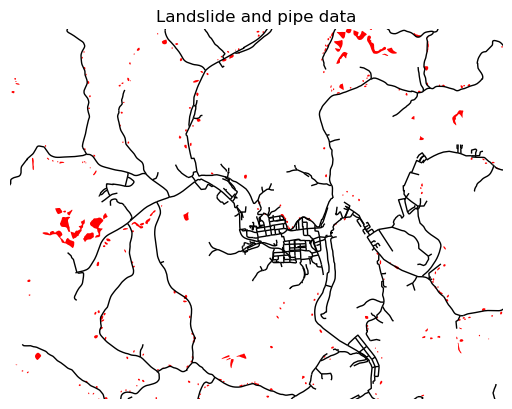

In [15]:
# Plot the landslide data along with pipes
ax = landslide_data.plot(color='red', label='Landslide data')
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('Landslide and pipe data')
tmp = ax.axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Load Social Vulnerability Index (SVI) GIS data
The social vulnerability data used in this tutorial was downloaded from the [Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html). The data contains census and social vulnerability metrics for each census tract. 

The quantity of interest used in this analysis is `RPL_THEMES` which ranks vulnerability across socioeconomic status, household characteristics, racial and ethnic minority status, and housing type and transportation.  The value ranges between 0 and 1, where higher values are associated with higher vulnerability.

Citation: Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry/Geospatial Research, Analysis, and Services Program. CDC/ATSDR Social Vulnerability Index 2020 Database Kentucky. https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html. Accessed on 4/4/2024.

In [16]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file. 
# The region of interest (ROI) was defined above.
"""
svi_file = '../data/SVI2020_KENTUCKY_tract.gdb'
svi_data = gpd.read_file(svi_file, driver="FileGDB", layer='SVI2020_KENTUCKY_tract')
print(svi_data.crs)
svi_data.to_crs(crs, inplace=True)
svi_data = svi_data.clip(ROI)
svi_data.to_file("../data/ky10_svi_data.geojson", index=True, driver='GeoJSON')
"""

'\nsvi_file = \'../data/SVI2020_KENTUCKY_tract.gdb\'\nsvi_data = gpd.read_file(svi_file, driver="FileGDB", layer=\'SVI2020_KENTUCKY_tract\')\nprint(svi_data.crs)\nsvi_data.to_crs(crs, inplace=True)\nsvi_data = svi_data.clip(ROI)\nsvi_data.to_file("../data/ky10_svi_data.geojson", index=True, driver=\'GeoJSON\')\n'

In [17]:
# Load the SVI data from file and print the CRS to ensure it is in EPSG:3089.  
# The methods `to_crs` and `set_crs` can be used to change coordinate reference systems if needed.
svi_file = '../data/ky10_svi_data.geojson'
svi_data = gpd.read_file(svi_file).set_index('index') 
print(svi_data.crs)

svi_data.head()

EPSG:3089


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
index,,,,,,,,,,,,,,,,,,,,,
985,21,Kentucky,KY,21153,Magoffin,21153970400,"Census Tract 9704, Magoffin County, Kentucky",86.743212,1800,350,...,1.9,0.0,1.9,2.3,4.6,0.0,1.9,0.890448,0.022963,"POLYGON ((5728982.375 3796262.000, 5729188.785..."
984,21,Kentucky,KY,21153,Magoffin,21153970300,"Census Tract 9703, Magoffin County, Kentucky",52.577750,3003,557,...,1.2,0.0,1.2,0.0,1.2,0.0,1.2,0.663193,0.013949,"POLYGON ((5704604.870 3803859.255, 5704998.491..."
386,21,Kentucky,KY,21071,Floyd,21071920200,"Census Tract 9202, Floyd County, Kentucky",51.065440,1545,247,...,2.2,0.0,2.2,0.1,0.2,0.0,2.2,0.720409,0.013818,"POLYGON ((5791479.459 3801489.293, 5791780.699..."
398,21,Kentucky,KY,21071,Floyd,21071921002,"Census Tract 9210.02, Floyd County, Kentucky",33.362472,3746,688,...,0.9,0.0,0.9,2.2,2.4,0.0,0.9,0.568973,0.008858,"MULTIPOLYGON (((5733681.449 3796634.816, 57344..."
385,21,Kentucky,KY,21071,Floyd,21071920100,"Census Tract 9201, Floyd County, Kentucky",12.503479,2889,382,...,1.2,0.0,1.2,0.9,1.7,0.0,1.2,0.386356,0.003420,"POLYGON ((5782256.522 3796262.000, 5782551.583..."


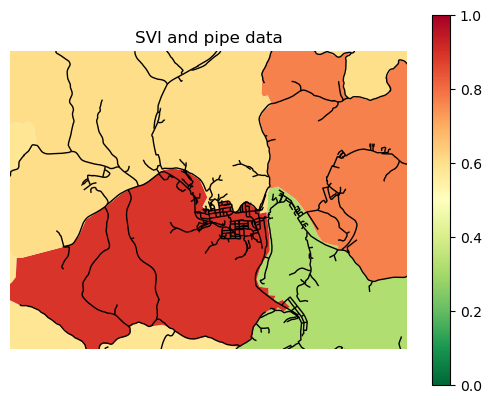

In [18]:
# Plot SVI data and pipes (higher values of SVI are associated with higher vulnerability)
ax = svi_data.plot(column='RPL_THEMES', label='SVI data', cmap='RdYlGn_r', vmin=0, vmax=1, legend=True)
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('SVI and pipe data')
tmp = ax.axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Expand the size of each landslide using a buffer
Each landslide is extended to include the surrounding 1000 ft, to create a region that might be impacted by an individual landslide.  The distance unit for buffering matches the distance unit of the CRS (ft).
This assumption could be replaced with detailed landslide analysis that includes slope, soil type, weather conditions, and pipe material. 

In [19]:
# Create a GeoDataFrame to hold information used in landslide scenarios (initially copied from landslide_data)
# Buffer each landslide polygon by 1000 ft
landslide_scenarios = landslide_data.copy()
landslide_scenarios['geometry'] = landslide_data.buffer(1000)

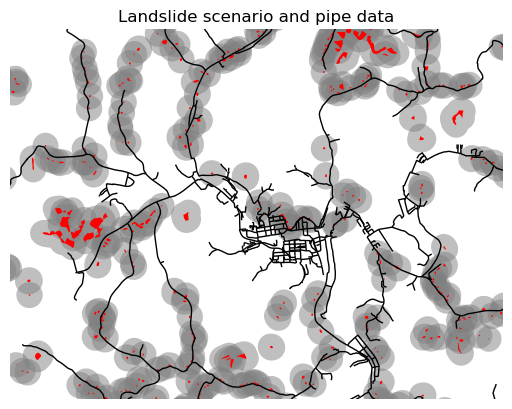

In [20]:
# Plot the landslide data, region included in each landslide scenario, and pipes
ax = landslide_scenarios.plot(color='gray', alpha=0.5)
ax = landslide_data.plot(color='red', label='Landslide data', ax=ax)
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('Landslide scenario and pipe data')
tmp = ax.axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

# Geospatial Intersects
In this section, landslide scenario and SVI data are interested with pipes and junctions in the `WaterNetworkModel`.

## Identify pipes that intersect each landslide
Landslide polygons are intersected with pipes to obtain a list of pipes that intersect each landslide.  The pipe attribute `length` is also included in the intersection to gather statistics on the pipe length that intersects each landslide.  <font color='red'>This information is used to build landslide scenarios.</font>

In [21]:
# Use the intersect function to determine pipes and pipe length that intersects each landslide
A = landslide_scenarios
B = wn_gis.pipes
B_value = 'length'
landslide_intersect = wntr.gis.intersect(A, B, B_value)

# Print results in order of descending total pipe length
landslide_intersect.sort_values('sum', ascending=False).head()

,intersections,values,n,sum,min,max,mean
6470,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
6471,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
6456,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
5063,"[P-244, P-83]","[12708.2156808, 520.2234960000001]",2,13228.439177,520.223496,12708.215681,6614.219588
5064,"[P-244, P-83]","[12708.2156808, 520.2234960000001]",2,13228.439177,520.223496,12708.215681,6614.219588


In [22]:
# Add the intersection results to the landslide scenario data
landslide_scenarios[['intersections', 'n', 'total pipe length']] = landslide_intersect[['intersections', 'n', 'sum']]

# Print results in order of descending total pipe length
landslide_scenarios.sort_values('total pipe length', ascending=False).head()

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n,total pipe length
6470,Landslide,Oil Springs,3,505.785629,17813.235857,"POLYGON ((5731632.245 3843127.579, 5731676.251...","[P-145, P-190, P-389]",3,14068.107703
6471,Landslide,Oil Springs,3,885.366978,46428.920611,"POLYGON ((5731968.886 3842927.394, 5731968.570...","[P-145, P-190, P-389]",3,14068.107703
6456,Landslide,Oil Springs,3,731.639387,40250.058481,"POLYGON ((5732906.128 3842944.427, 5732888.288...","[P-145, P-190, P-389]",3,14068.107703
5063,Landslide,SITKA,3,432.545161,12300.359938,"POLYGON ((5762828.918 3877978.663, 5762925.073...","[P-244, P-83]",2,13228.439177
5064,Landslide,SITKA,3,374.893710,8458.630241,"POLYGON ((5763551.762 3877868.449, 5763622.783...","[P-244, P-83]",2,13228.439177


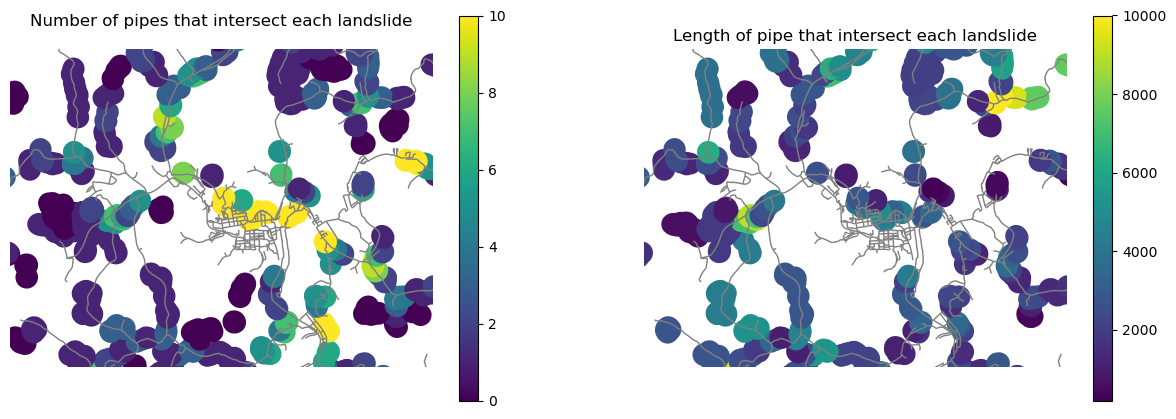

In [23]:
# Plot intersection results
fig, axes = plt.subplots(1,2, figsize=(15,5))

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[0])
landslide_scenarios.plot(column='n', vmax=10, legend=True, ax=axes[0])
tmp = axes[0].set_title('Number of pipes that intersect each landslide')
tmp = axes[0].axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = axes[0].set_xlim(zoom_coords[0])
tmp = axes[0].set_ylim(zoom_coords[1])

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[1])
landslide_scenarios.plot(column='total pipe length', vmax=10000, legend=True, ax=axes[1])
tmp = axes[1].set_title('Length of pipe that intersect each landslide')
tmp = axes[1].axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = axes[1].set_xlim(zoom_coords[0])
tmp = axes[1].set_ylim(zoom_coords[1])

## Identify landslides that intersect each pipe
Pipes are intersected with landslides to obtain a list of landslides that intersect each pipe. The landslide attribute `Confidence_Ranking` is also included in the intersection to gather statistics on landslide confidence for each pipe.  <font color='red'>While this information is not used in the analysis below, this type of information could be used to inform uncertainty or probability of damage.</font>

Note that `Confidence_Ranking` has a value of 3 for each landslide in region of interest. A value of 3 indicates "Landslide likely at or near the specified location".  More information on Confidence ranking can be found at https://kgs.uky.edu/kgsmap/helpfiles/landslide_help.shtm.  Since the values are uniform in this dataset, the intersected sum, min, max, and mean are all the same value.

In [24]:
# Use the intersect function to determine landslides and landslide confidence ranking that intersects each pipe
A = wn_gis.pipes
B = landslide_scenarios
B_value = 'Confidence_Ranking'
pipe_intersect = wntr.gis.intersect(A, B, B_value)

# Print results in order of descending number of intersections.
pipe_intersect.sort_values('n', ascending=False).head()

,intersections,values,n,sum,min,max,mean,weighted_mean
P-449,"[5086, 5087, 5088, 5125, 5126, 5128, 5129, 513...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",25,75.0,3.0,3.0,3.0,3.0
P-517,"[4553, 4554, 4555, 4556, 4557, 4558, 4559, 456...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-722,"[6831, 6832, 6833, 6834, 6835, 6836, 6840, 684...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-837,"[4571, 4575, 4631, 4632, 4633, 4634, 4635, 463...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-442,"[6836, 6837, 6838, 6839, 6840, 6856, 6857, 685...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",20,60.0,3.0,3.0,3.0,3.0


In [25]:
# Add the intersection results to the GIS pipe data
wn_gis.pipes[['intersections', 'n', 'Confidence_Ranking']] = pipe_intersect[['intersections', 'n', 'mean']]

# Print results in order of descending number of intersections
wn_gis.pipes.sort_values('n', ascending=False).head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry,intersections,n,Confidence_Ranking
P-449,Pipe,J-276,J-616,False,0.1016,Open,6482.077968,0.0,150.0,"LINESTRING (5760308.720 3869886.000, 5760219.9...","[5086, 5087, 5088, 5125, 5126, 5128, 5129, 513...",25,3.0
P-517,Pipe,J-581,J-677,False,0.1524,Open,7388.440087,0.0,100.0,"LINESTRING (5728134.870 3878198.000, 5728149.0...","[4553, 4554, 4555, 4556, 4557, 4558, 4559, 456...",23,3.0
P-722,Pipe,J-612,J-551,False,0.1016,Open,2962.692576,0.0,100.0,"LINESTRING (5768267.590 3848120.000, 5768281.8...","[6831, 6832, 6833, 6834, 6835, 6836, 6840, 684...",23,3.0
P-837,Pipe,J-236,J-860,False,0.1016,Open,7194.294984,0.0,100.0,"LINESTRING (5728952.110 3898156.000, 5725889.4...","[4571, 4575, 4631, 4632, 4633, 4634, 4635, 463...",23,3.0
P-442,Pipe,J-454,J-607,False,0.0762,Open,2015.419896,0.0,150.0,"LINESTRING (5778153.330 3852424.000, 5777683.2...","[6836, 6837, 6838, 6839, 6840, 6856, 6857, 685...",20,3.0


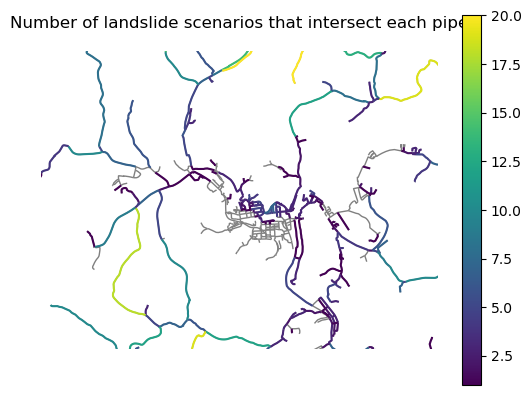

In [26]:
# Plot intersection results
ax = wn_gis.pipes.plot(color='gray', linewidth=1, zorder=1)
wn_gis.pipes[wn_gis.pipes['n'] > 0].plot(column='n', vmax=20, legend=True, ax=ax)
tmp = ax.set_title('Number of landslide scenarios that intersect each pipe')
tmp = ax.axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Assign social vulnerability to each junction
Junctions are intersected with SVI to determine the social vulnerability of the population at each junction.  The SVI data attribute `RPL_THEMES` is included in the intersection. <font color='red'>This information is used to determine the social vulnerability of individuals that experience water service disruptions.</font>

The SVI data column `RPL_THEMES` ranks vulnerability across socioeconomic status, household characteristics, racial and ethnic minority status, and housing type and transportation. The value ranges between 0 and 1, where higher values are associated with higher vulnerability.

Note that since each junction only intersects one census tract, the SVI sum, min, max, and mean are all the same value.

In [27]:
# Use the intersect function to determine SVI of each junction.  
A = wn_gis.junctions
B = svi_data
B_value = 'RPL_THEMES'
junction_svi = wntr.gis.intersect(A, B, B_value)

junction_svi.head()

,intersections,values,n,sum,min,max,mean
J-1,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-10,[787],[0.6015],1,0.6015,0.6015,0.6015,0.6015
J-100,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-101,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-102,[790],[0.8942],1,0.8942,0.8942,0.8942,0.8942


In [28]:
# Add the intersection results (SVI value) to the GIS junction data
wn_gis.junctions['RPL_THEMES'] = junction_svi['mean']

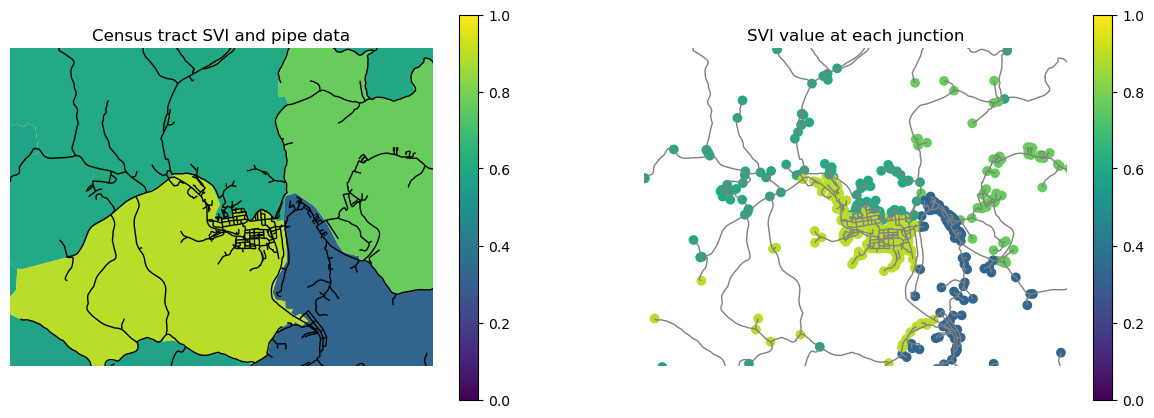

In [29]:
# Plot SVI for each census tract and SVI assigned to each junction
fig, axes = plt.subplots(1,2, figsize=(15,5))

svi_data.plot(column='RPL_THEMES', label='SVI data', vmin=0, vmax=1, legend=True, ax=axes[0])
wn_gis.pipes.plot(color='black', linewidth=1, ax=axes[0])
tmp = axes[0].set_title('Census tract SVI and pipe data')
tmp = axes[0].axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = axes[0].set_xlim(zoom_coords[0])
tmp = axes[0].set_ylim(zoom_coords[1])

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[1])
wn_gis.junctions.plot(column='RPL_THEMES', vmin=0, vmax=1, legend=True, ax=axes[1])
tmp = axes[1].set_title('SVI value at each junction')
tmp = axes[1].axis('off')
# Uncomment the following lines to zoom in on the network graphic
tmp = axes[1].set_xlim(zoom_coords[0])
tmp = axes[1].set_ylim(zoom_coords[1])

# Hydraulic Simulations
The following section runs hydraulic simulations for the baseline (no landslide) and landslide scenarios. A subset of landslide scenarios is run to simply the tutorial.  Simulation results are stored for later analysis.

In [30]:
# Create a function to setup the WaterNetworkModel for hydraulic simulations
def model_setup(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'
    wn.options.hydraulic.required_pressure = 20 # m
    wn.options.hydraulic.minimum_pressure  = 0 # m
    wn.options.time.duration = 48*3600 # s (48 hour simulation)
    return wn

## Run baseline simulation

In [31]:
# Run a baseline simulation, with no landslide or damage.  
wn = model_setup(inp_file)
sim = wntr.sim.EpanetSimulator(wn)
baseline_results = sim.run_sim()

In [32]:
# View a subset of the simulation results
baseline_results.node['pressure'].head()

name,J-1,J-10,J-100,J-101,J-102,J-103,J-104,J-105,J-106,J-107,...,T-12,T-13,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9
0,74.436096,93.883575,75.054901,56.504501,79.781960,80.306419,80.960396,76.481995,71.050392,48.732750,...,48.268768,21.482943,25.196871,20.663641,25.789127,40.953812,31.307989,43.370964,37.115768,45.291481
3600,72.626770,93.926659,73.575287,55.026379,78.615036,79.008041,79.665916,75.915871,68.352432,45.943596,...,48.307049,22.350798,26.607130,19.956594,25.629583,41.060223,33.707394,40.527977,38.078613,43.470959
7200,72.612076,93.998695,72.497734,53.949440,77.646591,77.932076,78.592903,75.449539,66.180450,43.698956,...,48.375103,23.294777,27.943420,19.283707,25.508699,41.156776,35.659664,38.239334,37.965950,43.485413
10800,70.842583,94.103836,74.100410,55.552116,76.951103,77.155655,77.818398,75.145515,64.678635,42.147442,...,48.483711,24.276857,29.196718,18.834841,25.407606,41.242203,37.154884,36.656883,38.824856,41.684631
14400,70.019829,94.199722,72.454834,53.905777,75.698730,75.836235,76.502129,74.287300,62.405041,39.813576,...,48.586102,25.254545,29.768871,18.834841,25.306515,41.356148,38.309959,35.750965,39.084675,40.887024


## Run landslide scenarios
Landslide scenarios are downselected by identifying the set of landslides that impact a unique set of pipes.  Scenarios are further downselected to 6 scenarios to simplify the tutorial.  A hydraulic simulation is run for each landslide scenario, where pipes that intersect the landslide are closed for 48 hours.  Results from each scenario are stored for later analysis.

In [33]:
# Remove scenarios with no intersecting pipes
landslide_scenarios = landslide_scenarios[landslide_scenarios['n'] > 0]
landslide_scenarios = landslide_scenarios[~landslide_scenarios['n'].isna()]

# Downselect landslide scenarios that impact a unique set of pipes
duplicated_intersections = landslide_scenarios['intersections'].astype(str).duplicated()
landslide_scenarios = landslide_scenarios.loc[~duplicated_intersections, :]

print('Number of unique landslide scenarios', landslide_scenarios.shape[0])
landslide_scenarios.head()

Number of unique landslide scenarios 297


,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n,total pipe length
7446,Landslide,Prestonsburg,3,409.918475,12622.961069,"POLYGON ((5760551.485 3803408.818, 5760529.266...","[P-1020, P-204, P-970]",3,1766.223950
7441,Landslide,Prestonsburg,3,460.868108,15842.025707,"POLYGON ((5761388.818 3804294.854, 5761396.311...",[P-1020],1,925.975999
7437,Landslide,Prestonsburg,3,2354.389541,193371.451658,"POLYGON ((5753684.221 3804191.312, 5753646.740...","[P-101, P-7, P-858]",3,3503.602848
7439,Landslide,Prestonsburg,3,558.451622,21568.723836,"POLYGON ((5761789.488 3805153.688, 5761796.372...","[P-1020, P-533, P-616]",3,1312.395343
7438,Landslide,Prestonsburg,3,635.853700,27012.188457,"POLYGON ((5754931.213 3806041.076, 5755004.976...","[P-101, P-7]",2,1607.588352


In [34]:
# Further downselect the landslide scenarios for demonstration purposes. Choose one of the following 4 options.
# Option 1. 6 scenarios that illustrate a wide range of impact
landslide_scenarios_downselect = landslide_scenarios.loc[[4495, 7003, 7111, 5086, 6966, 7058],:] 

# Option 2. 6 scenarios with the highest intersecting pipe length
#landslide_scenarios_downselect = landslide_scenarios.sort_values('total pipe length', ascending=False).iloc[0:6,:]

# Option 3. 6 scenarios with the highest number of intersecting pipes
#landslide_scenarios_downselect = landslide_scenarios.sort_values('n', ascending=False).iloc[0:6,:]

# Option 4. Random selection of 6 scenarios
#landslide_scenarios_downselect = landslide_scenarios.sample(n=6, random_state=1234)

landslide_scenarios_downselect

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n,total pipe length
4495,Landslide,REDBUSH,3,752.101468,37221.974670,"POLYGON ((5746862.499 3866709.655, 5746938.513...",[P-812],1,1944.444168
7003,Landslide,Paintsville,3,330.770413,7065.011733,"POLYGON ((5775407.596 3833657.199, 5775367.408...","[P-140, P-146, P-148, P-159, P-371, P-384, P-4...",19,4171.164226
7111,Landslide,Paintsville,3,508.895469,19175.573922,"POLYGON ((5756274.326 3819451.145, 5756227.630...","[P-175, P-231, P-480, P-700, P-730, P-846, P-863]",7,9264.245734
5086,Landslide,SITKA,3,424.594199,10922.156471,"POLYGON ((5760065.228 3870950.739, 5760160.763...","[P-163, P-449, P-725]",3,12063.825199
6966,Landslide,Paintsville,3,562.617615,22816.595980,"POLYGON ((5765524.598 3837687.738, 5765477.659...","[P-640, P-81, P-839, P-880, P-942, P-946, P-95...",8,2596.493054
7058,Landslide,Paintsville,3,631.296149,28012.891694,"POLYGON ((5775378.255 3824900.407, 5775416.447...","[P-329, P-417, P-435, P-519, P-709, P-783, P-89]",7,3432.586582


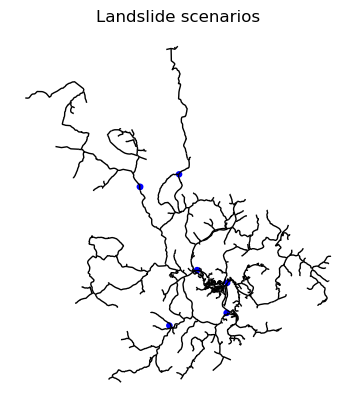

In [35]:
# Plot the location of landslides used in the analysis
ax = landslide_scenarios_downselect.plot(color='blue')
wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
tmp = ax.set_title('Landslide scenarios')
tmp = ax.axis('off')

In [36]:
# Run a hydraulic simulation for each landslide scenario, store results in a dictionary
# Each scenario closes all pipes that intersect the landslide for the 48 hour simulation
results = {}
for i, scenario in landslide_scenarios_downselect.iterrows():
    wn = model_setup(inp_file)
    for pipe_i in scenario['intersections']:
        pipe_object = wn.get_link(pipe_i)
        pipe_object.initial_status = 'CLOSED'
    sim = wntr.sim.EpanetSimulator(wn)
    results[i] = sim.run_sim()

# Analysis Results
The following section computes and plots analysis results, including water service availability (WSA) and the social vulnerability index (SVI) of impacted junctions for each scenario.

## Water Service Availability (WSA)
Water service availability (WSA) is the ratio of delivered demand to the expected demand.  WSA is computed for each junction (alternatively, WSA can be computed for each timestep, or for each junction and timestep).  A value below 1 indicates that expected demand it me, while a value of 0 indicates that the expected demand is not met. 

In [37]:
# Compute expected demand for each junction and timestep
expected_demand = wntr.metrics.expected_demand(wn)

expected_demand.head()

,J-1,J-10,J-100,J-101,J-102,J-103,J-104,J-105,J-106,J-107,...,O-Pump-5,I-Pump-6,I-Pump-7,O-Pump-8,O-Pump-9,O-RV-1,I-RV-2,I-RV-3,O-RV-4,I-RV-5
0.0,0.000014,0.000065,0.000127,0.000090,0.000005,0.000009,0.000006,0.000012,0.000020,0.000003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600.0,0.000011,0.000049,0.000096,0.000068,0.000004,0.000007,0.000004,0.000009,0.000015,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200.0,0.000009,0.000041,0.000081,0.000057,0.000003,0.000006,0.000004,0.000008,0.000013,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800.0,0.000009,0.000041,0.000081,0.000057,0.000003,0.000006,0.000004,0.000008,0.000013,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14400.0,0.000011,0.000051,0.000100,0.000071,0.000004,0.000007,0.000005,0.000010,0.000016,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Compute total expected demand at each junction
expected_demand_j = expected_demand.sum(axis=0)

expected_demand_j

J-1       0.002042
J-10      0.009539
J-100     0.018622
J-101     0.013197
J-102     0.000701
            ...   
O-RV-1    0.000000
I-RV-2    0.000000
I-RV-3    0.000000
O-RV-4    0.000000
I-RV-5    0.000000
Length: 920, dtype: float64

In [39]:
# Compute baseline WSA for each junction
demand_baseline = baseline_results.node['demand'].loc[:,wn.junction_name_list]
demand_baseline_j = demand_baseline.sum(axis=0) # total demand at each junction
wsa_baseline_j = wntr.metrics.water_service_availability(expected_demand_j, demand_baseline_j)

wsa_baseline_j.head()

name
J-1      0.994994
J-10     0.979076
J-100    1.000094
J-101    0.976837
J-102    1.003030
dtype: float64

In [40]:
# Add WSA from the base simulation to the junction GIS data
wn_gis.junctions['baseline'] = wsa_baseline_j

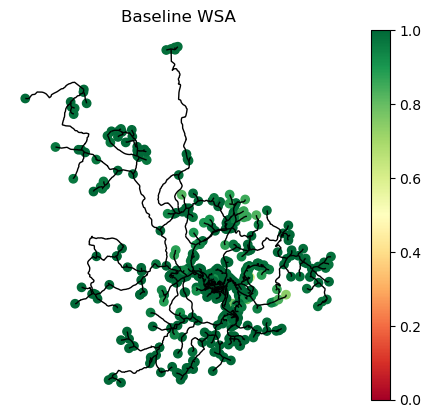

In [41]:
# Plot WSA from the base simulation
ax = wn_gis.pipes.plot(color='black', linewidth=1)
ax = wn_gis.junctions.plot(column='baseline', cmap='RdYlGn', vmin=0, vmax=1, legend=True, ax=ax)
tmp = ax.set_title('Baseline WSA')
tmp = ax.axis('off')

In [42]:
# Compute WSA associated with each landslide scenarios
for i, scenario in landslide_scenarios_downselect.iterrows():
    demand = results[i].node['demand'].loc[:,wn.junction_name_list]
    demand_j = demand.sum(axis=0) # total demand at each junction
    wsa_j = wntr.metrics.water_service_availability(expected_demand_j, demand_j)
    
    # Add WSA to the junction GIS data
    column_name = 'scenario'+str(i)
    wn_gis.junctions[column_name] = wsa_j
    print(i, len(scenario['intersections']), wsa_j.mean())

4495 1 0.9562821372138003
7003 19 0.8218488117311916
7111 7 0.9766571063720993
5086 3 0.9890748355173563
6966 8 0.9210546473052833
7058 7 0.9401817890559534


In [43]:
# Extract WSA for each scenario 
column_names = ['scenario'+str(i) for i in landslide_scenarios_downselect.index]
wsa_results = wn_gis.junctions[column_names]

wsa_results.head()

,scenario4495,scenario7003,scenario7111,scenario5086,scenario6966,scenario7058
J-1,1.000879,0.955301,1.000744,1.000750,0.222644,0.991877
J-10,1.000278,0.953388,0.986847,0.224127,0.746386,0.983880
J-100,1.000114,1.000079,1.000106,1.000099,0.271720,1.000080
J-101,1.000097,0.892301,1.000086,0.994608,0.139309,0.952506
J-102,1.003433,1.002577,1.003204,1.003148,1.003491,1.003377


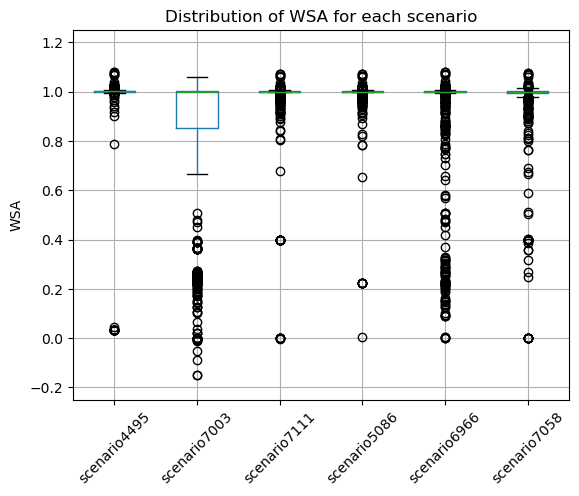

In [44]:
# Plot distribution of WSA for each scenario. Note that WSA can be > 1 and < 0 due to numerical differences in expected and actual demand. 
# For certain types of analysis, the WSA should be truncated to values between 0 and 1.
ax = wsa_results.boxplot(rot=45)
tmp = ax.set_ylim(-0.25, 1.25)
tmp = ax.set_ylabel('WSA')
tmp = ax.set_title('Distribution of WSA for each scenario')

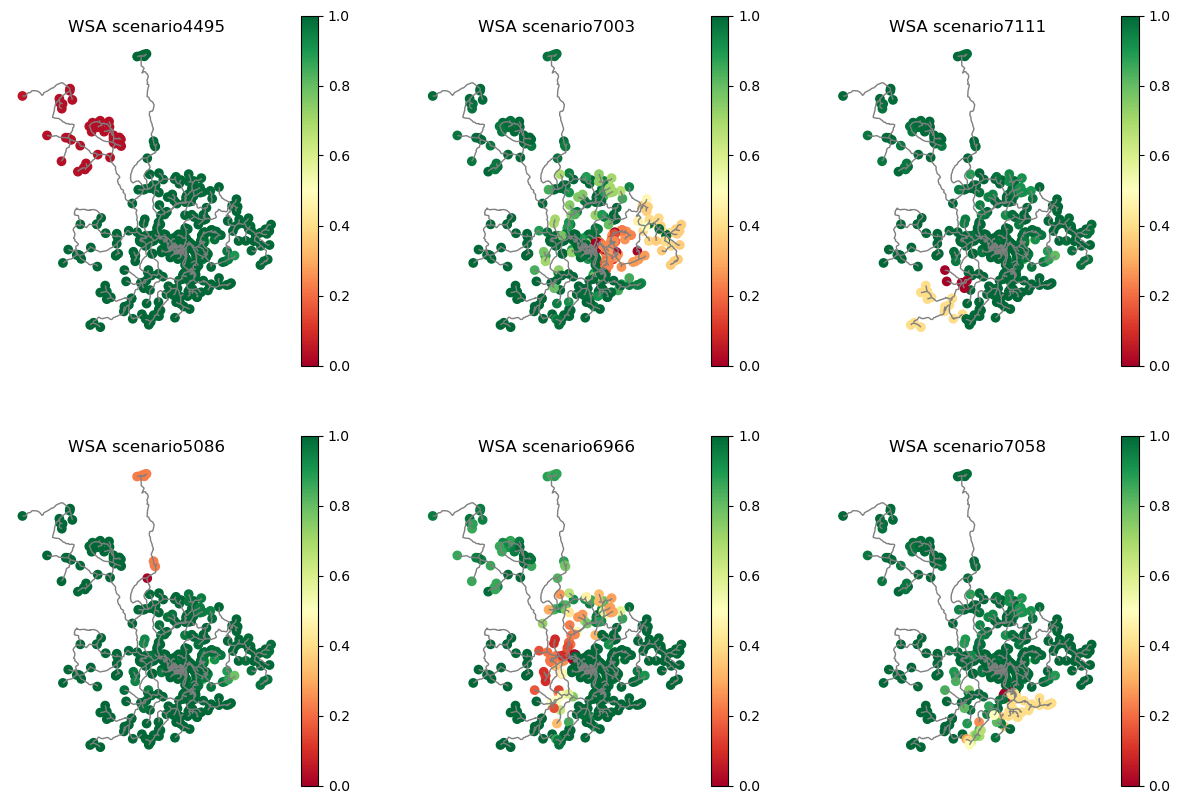

In [45]:
# Plot WSA for each scenario
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()

for i, scenario in enumerate(wsa_results.columns):
    wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[i]) # pipes
    wn_gis.junctions.plot(column=scenario, cmap='RdYlGn', vmin=0, vmax=1, legend=True, ax=axes[i]) # junction wsa
    tmp = axes[i].set_title('WSA '+scenario)
    tmp = axes[i].axis('off')
    if i >= 6: # axes is defined to have 6 subplots
        break

## SVI of impacted junctions
In this analysis, impacted junctions are defined as junctions where WSA falls below 0.5 (50% of the expected water was received) at any time during the simulation. Other criteria could also be used to defined impact.

In [46]:
# Extract junctions that are impacted by WSA < 0.5 for each scenario
impacted_junctions = {}
for scenario in wsa_results.columns:
    filter = wsa_results[scenario] < 0.5
    impacted_junctions[scenario] = wsa_results.index[filter]

impacted_junctions

{'scenario4495': Index(['J-149', 'J-150', 'J-17', 'J-170', 'J-171', 'J-182', 'J-183', 'J-188',
        'J-210', 'J-211', 'J-236', 'J-312', 'J-325', 'J-37', 'J-38', 'J-410',
        'J-411', 'J-463', 'J-464', 'J-470', 'J-492', 'J-540', 'J-581', 'J-6',
        'J-617', 'J-677', 'J-686', 'J-70', 'J-726', 'J-781', 'J-787', 'J-797',
        'J-801', 'J-803', 'J-816', 'J-834', 'J-843', 'J-860', 'J-883', 'J-9',
        'J-919'],
       dtype='object'),
 'scenario7003': Index(['J-13a', 'J-13b', 'J-153', 'J-154', 'J-157', 'J-158', 'J-162', 'J-163',
        'J-165', 'J-166',
        ...
        'J-880', 'J-891', 'J-892', 'J-893', 'J-895', 'J-900', 'J-905', 'J-908',
        'J-928', 'J-931'],
       dtype='object', length=168),
 'scenario7111': Index(['J-14', 'J-172', 'J-202', 'J-203', 'J-296', 'J-297', 'J-385', 'J-386',
        'J-504', 'J-505', 'J-591', 'J-639', 'J-640', 'J-641', 'J-644', 'J-651',
        'J-731', 'J-732', 'J-758', 'J-795', 'J-810', 'J-823', 'J-912', 'J-921'],
       dtype='obj

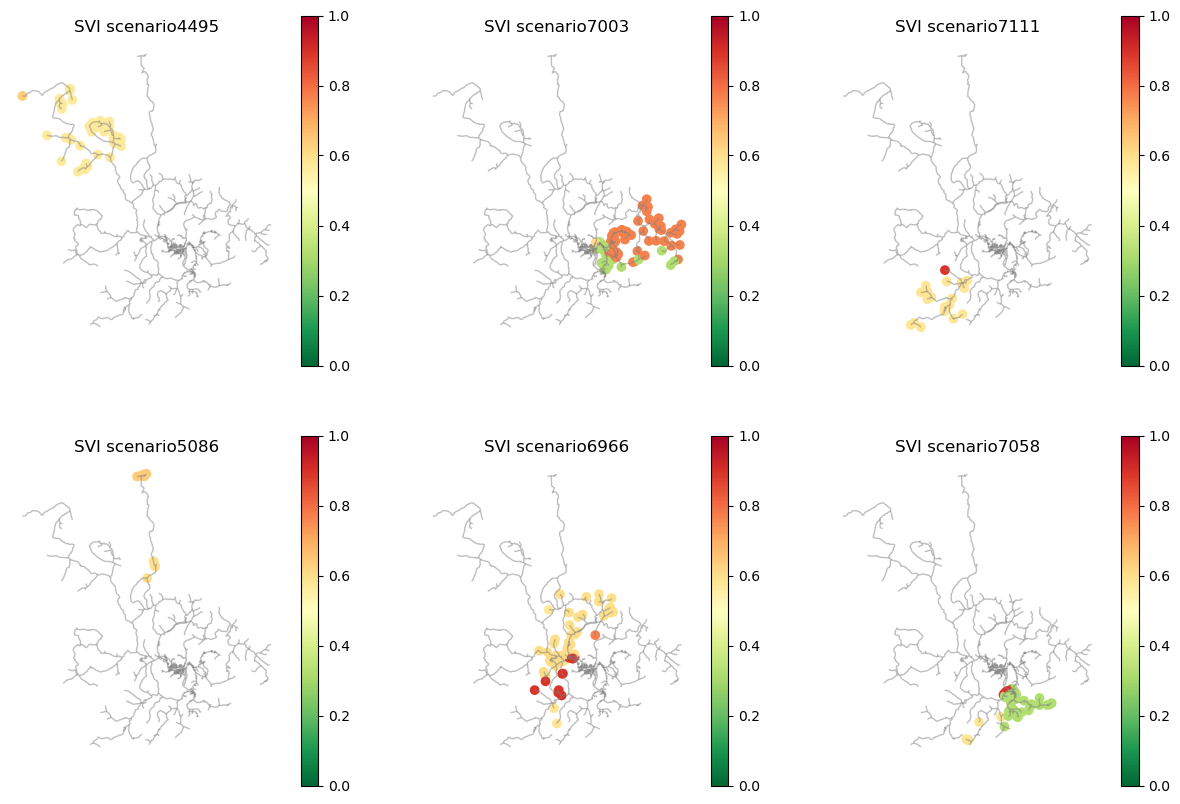

In [47]:
# Plot SVI of impacted junctions for each scenario
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()

for i, scenario in enumerate(wsa_results.columns):
    j = impacted_junctions[scenario]
    wn_gis.pipes.plot(color='gray', linewidth=1, alpha=0.5, ax=axes[i]) # pipes
    if len(j) > 0:
        wn_gis.junctions.loc[j,:].plot(column='RPL_THEMES', cmap='RdYlGn_r', vmin=0, vmax=1, legend=True, ax=axes[i]) # junction wsa
    tmp = axes[i].set_title('SVI '+scenario)
    tmp = axes[i].axis('off')
    if i >= 6: # axes is defined to have 6 subplots
        break

## Save analysis results to GIS files
The analysis above stored WSA results for each scenario to the `wn_gis` object, which can be saved to GIS formatted files and loaded into GIS software platforms for further analysis.  Note that lists (such as the information stored in 'intersections') is not JSON serializable and must first be removed. 

In [48]:
del wn_gis.pipes['intersections']
wn_gis.write_geojson('ky10_analysis_results')